# Generating input data for urbs <a id='start'></a>
This notebook was written by Leonhard Odersky and Magdalena Dorfner. This notebook is licensed under the [GNU General Public License v3.0](https://www.gnu.org/licenses/gpl-3.0.en.html)

In this notebook the pre-processing for data in urbs is done. This includes retrieving, editing and adapting data from different sources. 

The notebook can be split in the following parts:
* General [Input](#input)
* [Aggregation](#aggregation) of
    * [power plant capacities](#capacities),
    * [storage constraints](#storage),
    * the [transmission grid](#transmisson),
    
   
* generating [timeseries](#timeseries) for
    * the [demand](#demand),
    * [supply intermittent](#supim) modelling,
        

Each part is structured the same. Firstly, used packages are imported. Secondly, the input is defined. Thirdly, the data is edited. And in the end, the new generated dataframe is saved.

To run this notebook correctly, in each part the cells have to be excecuted in the right order.

***
***

# General Input<a id='input'></a>
<div style="text-align: right"> Back to [beginning](#start).</div>
Packages and data, which is used in all parts, are loaded.
Also, so global parameters are defined.

#### <center>  This part has to be excecuted at the very beginning! </center> 

In [1]:
import os
import define
import numpy as np
import pandas as pd
from datetime import datetime

# Define folders
folder_in = 'Input'
folder_out = 'Output'

# Define subfolders for different parts
agg_subfolder = 'Aggregation'
ts_subfolder = 'Timeseries'

# Define data types
dt_csv = '.csv'
dt_xlsx = '.xlsx'
dt_png = '.png'

# Importing list of German states in German and in English
states_de = define.states_de
states_en = define.states_en

# Importing dict to translate state names to English
states_translation = define.states_translation_de_en

# Deactivate warnings for changing values in dataframe
pd.options.mode.chained_assignment = None

***
***


## Aggregation <a id='aggregation'></a> 
<div style="text-align: right"> Back to [beginning](#start).</div>

***

### Power Plant Capacities<a id='capacities'></a> 
<div style="text-align: right"> Back to [beginning](#start).</div>

In the following cells, an Excel File with the capacities for all german power plants subdivided by their states and types is generated. For this, data from the [Open Power System Data platform](https://data.open-power-system-data.org/) (OPSD) is used (primary data from various sources, for a complete list see URL). It is read in, edited and saved to an excel file.


#### Input
All necessary data is read in from the OPSD files.

In [2]:
# Define input
cap_conv_file = 'conventional_power_plants_DE'
cap_ren_file = 'renewable_power_plants_DE'

cap_conv_path = os.path.join(folder_in, agg_subfolder, 
                             cap_conv_file+dt_csv)
cap_ren_path = os.path.join(folder_in, agg_subfolder, 
                            cap_ren_file+dt_csv)

# Importing dict to translate shorten state names to full ones
cap_translation_short = define.states_translation_sh_lo

# Define dict to rename energies
cap_aggregation = {
    'Hydro': 'Hydro plant',
    'Other': 'Other plant',
    'Bio': 'Biomass plant'}

In [3]:
# Read in data from conventional and renewable power plants

# Used columns for cap_conv_data:
# 0: id - identify each plant
# 8: state - assign each plant to its state
# 10: capacity_net_bnetza - capacity of each plant
# 12: fuel - sort plants into different types
# 13: technology - sort plants into different types
# 20: status - check if plant is still running
cap_conv_data = pd.read_csv(cap_conv_path, index_col=0, usecols=[0,8,10,12,13,20])

# Used columns for cap_ren_data:
# 3: energy_source_level_2 - sort plants into different types
# 5: technology - sort plants into different types
# 6: electrical_capacity - capacity of each plant
# 11: dso_id - check if plant is running
# 14: federal_state - assign each plant to its state
cap_ren_data = pd.read_csv(cap_ren_path, usecols=[3,5,6,11,14])

#### Editing
In the following two dataframes are created. In `cap_ren` the capacities of the renewable power plants of each state subdivided by types are collected. In `cap_conv` the capacitys of the conventional power plants of each state subdivided by types are collected. The data is filtered, assigned to their state and concatenate in one dataframe.

In [4]:
# Generating new dataframe renew_caps 
cap_ren = pd.DataFrame()

# Filter for active power plants
for lvfuel in set(cap_ren_data.energy_source_level_2.values):
    helpdf = cap_ren_data.loc[(cap_ren_data.energy_source_level_2 == lvfuel) 
                              & (cap_ren_data.dso_id.fillna(0) != 0)]
    
    # Sum capacity per state for each fuel type 
    for lv in set(helpdf.federal_state.values):
        #print (lv)
        help_sum = helpdf.loc[helpdf.federal_state == lv].electrical_capacity.sum()
        cap_ren.loc[lv, lvfuel+' plant']= help_sum

cap_ren.fillna(0, inplace=True)
cap_ren = cap_ren.rename(cap_translation_short)
cap_ren.sort_index()

,Wind plant,Bioenergy plant,Solar plant,Geothermal plant,Hydro plant,Other fossil fuels plant
AWZ,2773.65000,0.00000,0.00000,0.000,0.00000,0.000
Baden-Württemberg,679.57114,717.41391,5065.45075,0.000,370.69218,0.000
Bayern,1824.23820,1442.76827,11246.17609,25.415,609.67425,0.000
Berlin,9.00000,43.21620,81.97895,0.000,0.00000,0.000
Brandenburg,5847.81833,457.84850,2901.26572,0.000,4.65744,0.000
Bremen,177.39400,9.47994,40.16924,0.000,10.00000,0.000
Hamburg,65.34720,44.25535,37.26825,0.000,0.11000,0.000
Hessen,1206.01390,282.21211,1822.97656,0.000,62.78512,0.000
Mecklenburg-Vorpommern,3190.21025,363.37005,1373.23137,0.220,2.97620,0.000
Niedersachsen,8679.16790,1355.82315,3522.16643,0.000,59.54459,0.000


In [5]:
# Generating new dataframe conv_caps 
cap_conv = pd.DataFrame()

# Filter for active power plants
cap_conv_running = cap_conv_data.loc[ (cap_conv_data.status=='operating') 
                                | (cap_conv_data.status == 'reserve')]

# Create tuple with technology and fuel type
cap_conv_tecfuel = set(tuple(map(tuple,cap_conv_running.loc[:, ['technology', 'fuel']].values)))

# Run for each technoloy and fuel type tuple
for (lvtec,lvfuel) in cap_conv_tecfuel:
    helpdf = cap_conv_running.loc[(cap_conv_running.fuel == lvfuel)]
    
    # Run for each state
    for lv in set(helpdf.state.values):

        # Split fuel type 'Natural gas' in different technologies
        if lvfuel == 'Natural gas':
            help_sum = helpdf.loc[helpdf.technology == 'Combined cycle'].loc[
                helpdf.state == lv].capacity_net_bnetza.sum()
            cap_conv.loc[lv, 'CC plant']= help_sum
            helpdf = helpdf.loc[helpdf.technology != 'Combined cycle']
        
        # Split fuel type 'Hydro' in different technologies
        elif lvfuel == 'Hydro':
            help_sum = helpdf.loc[helpdf.technology == 'Pumped storage'].loc[
                helpdf.state == lv].capacity_net_bnetza.sum()
            cap_conv.loc[lv, 'Pump storage']= help_sum
            helpdf = helpdf.loc[helpdf.technology != 'Pumped storage']
            
        # Sum capacities for each fuel type
        help_sum = helpdf.loc[helpdf.state == lv].capacity_net_bnetza.sum()
        cap_conv.loc[lv, lvfuel+' plant']= help_sum
        helpdf = cap_conv_running.loc[(cap_conv_running.fuel == lvfuel)]

cap_conv.fillna(0, inplace=True)
cap_conv.sort_index()   

,Waste plant,Other fossil fuels plant,Oil plant,CC plant,Natural gas plant,Other fuels plant,Hard coal plant,Biomass and biogas plant,Lignite plant,Pump storage,Hydro plant,Nuclear plant
Baden-Württemberg,98.3,0.0,700.3,471.5,573.8,0.0,5506.2,215.8,0.0,1740.0,612.4,2712.0
Bayern,214.1,0.0,968.6,3531.1,861.3,6.0,846.9,66.4,0.0,263.0,1620.2,3982.0
Berlin,36.0,0.0,327.0,444.0,499.0,0.0,777.0,16.5,164.0,0.0,0.0,0.0
Brandenburg,117.9,0.0,333.5,282.0,451.3,124.5,0.0,85.0,4409.0,0.0,0.0,0.0
Bremen,91.0,0.0,88.0,459.3,0.0,160.0,769.0,0.0,0.0,0.0,9.9,0.0
Hamburg,24.0,0.0,38.0,127.0,22.5,0.0,1794.0,20.0,0.0,0.0,0.0,0.0
Hessen,108.1,0.0,24.8,606.2,1000.4,28.0,753.0,31.7,33.5,623.0,20.0,0.0
Luxemburg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1291.0,0.0
Mecklenburg-Vorpommern,17.0,0.0,0.0,183.0,135.4,0.0,514.0,27.6,0.0,0.0,0.0,0.0
Niedersachsen,74.7,0.0,56.0,2347.0,717.7,288.5,2893.3,115.5,352.0,220.0,0.1,2696.0


In [6]:
# Concatenate both data frames
cap_plants = pd.concat([cap_ren, cap_conv], axis=1)

# Rename fuel types
for key in cap_aggregation.keys():
    col_list = [col for col in cap_plants.columns if key in col]
    help_sum = cap_plants[col_list].sum(axis=1)
    cap_plants.drop(col_list, axis=1, inplace=True)
    cap_plants[cap_aggregation[key]] = help_sum

cap_plants = cap_plants.fillna(0).sort_index(axis=1)
cap_plants = cap_plants.rename({'AWZ':'Offshore'})

# Drop wrong regions
droplist = [np.nan, 'Luxemburg', 'Schweiz', 'Österreich']
cap_plants = cap_plants.drop(droplist).sort_index()

# Adding slack powerplants and curtailment
cap_slack = pd.DataFrame(index=cap_plants.index, 
                         columns=['Slack powerplant', 'Curtailment'], 
                         data=999999)
cap_plants = pd.concat([cap_plants, cap_slack], axis=1)

# Translating states
cap_plants = cap_plants.rename(states_translation)

cap_plants.sort_index(axis=1, inplace=True)
cap_plants.head(5)

,Biomass plant,CC plant,Curtailment,Geothermal plant,Hard coal plant,Hydro plant,Lignite plant,Natural gas plant,Nuclear plant,Oil plant,Other plant,Pump storage,Slack powerplant,Solar plant,Waste plant,Wind plant
Baden-Württemberg,933.21391,471.5,999999,0.000,5506.2,1966.18436,0.0,573.8,2712.0,700.3,0.0,1740.0,999999,5065.45075,98.3,679.57114
Bavaria,1509.16827,3531.1,999999,25.415,846.9,4459.74850,0.0,861.3,3982.0,968.6,6.0,263.0,999999,11246.17609,214.1,1824.23820
Berlin,59.71620,444.0,999999,0.000,777.0,0.00000,164.0,499.0,0.0,327.0,0.0,0.0,999999,81.97895,36.0,9.00000
Brandenburg,542.84850,282.0,999999,0.000,0.0,9.31488,4409.0,451.3,0.0,333.5,124.5,0.0,999999,2901.26572,117.9,5847.81833
Bremen,9.47994,459.3,999999,0.000,769.0,39.80000,0.0,0.0,0.0,88.0,160.0,0.0,999999,40.16924,91.0,177.39400


#### Output

In [7]:
# Define output
cap_plants_file = 'German Power Plant Capacities'
cap_plants_pump_file = 'German Pump Storage OPSD'

# Write pump storage to extra file in storage input,
# as it is needed later
cap_pump_subfolder = 'Storage'
cap_pump_path_out = os.path.join(folder_in, agg_subfolder, cap_pump_subfolder,
                                 cap_plants_pump_file+dt_xlsx)
try:
    cap_plants['Pump storage'].T.to_excel(cap_pump_path_out)
    cap_plants.drop(['Pump storage'], axis=1, inplace=True)
except:
    print('Dropped pump stroage already')

# Save remaining data to excel file
cap_path_out = os.path.join(folder_out, agg_subfolder, 
                            cap_plants_file+dt_xlsx)
cap_plants.T.to_excel(cap_path_out)

***

### Storage constraints <a id='storage'></a>
<div style="text-align: right"> Back to [beginning](#start).</div>

Here, the German storage constraints are constructed. Different sources where used for this:
- [FRESNA](https://github.com/FRESNA/powerplantmatching/tree/master/data/out) \[License: [GNU General Public License v3.0](https://github.com/FRESNA/powerplantmatching/blob/master/LICENSE)\]
- [OPSD](https://data.open-power-system-data.org/) (Primary data from various sources, for a complete list see URL)
- [ELMOD-DE](http://www.diw.de/elmod) \[License: [MIT License](https://opensource.org/licenses/MIT) and [ODbL](https://opendatacommons.org/licenses/odbl/)\]
- [Bundesnetzagentur](https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/Versorgungssicherheit/Erzeugungskapazitaeten/Kraftwerksliste/kraftwerksliste-node.html) \[License: [dl-de/by-2-0](https://www.govdata.de/dl-de/by-2-0)\]

Each input file is handled differently. Information to the pump storage is read in and aggreagted in a dataframe. This dataframe is saved to an excel file then.

The part of each source can be run separately from its first to its last cell, as long as that the 'Import' cell has been executed.

#### Import

In [8]:
from geopy.geocoders import Nominatim
from urllib.request import Request
import matplotlib.pyplot as plt
%matplotlib notebook
geo = Nominatim()

# Define subfolder
sto_subfolder = 'Storage'

#### [FRESNA](https://github.com/FRESNA/powerplantmatching/tree/master/data/out)
At first the storage constraints are constructed with data, which are taken from [FRESNA](https://github.com/FRESNA/powerplantmatching/tree/master/data/out). As the address of each power plant is not known, the address is requested with the geocode from nominatim. After some adoption to the data structure, it is saved to an excel file.

In [10]:
# Define input
sto_file_fre_in = 'fresna_storage_reduced'
sto_path_fre_in = os.path.join(folder_in, agg_subfolder, sto_subfolder, 
                            sto_file_fre_in+dt_csv)

# Read in data
# Used columns for sto_data_fre:
# 0: id - identify each plant
# 6: Technology - sort plants into typs
# 7: Country - filter for german plants
# 9: Capacity - capacity of each plant
# 11: lat - get address of plant
# 12: lon - get address of plant
sto_data_fre = pd.read_csv(sto_path_fre_in, index_col=0, usecols=[0,6,7,9,11,12])

# Filter data to Germany and pump storage
sto_fre = sto_data_fre.loc[(sto_data_fre.Country=='Germany') 
                           & (sto_data_fre.Technology=='Pumped Storage')]

# Add columns for addresses and states
sto_fre['address'] = np.nan
sto_fre['state'] = np.nan

# Get state for each plantand generate state with it
for key in sto_fre.index:
    
    # Request address from nominatim 
    lat, lon = sto_fre.lat[key], sto_fre.lon[key]
    cord = geo.reverse('%s, %s' % (lat, lon), timeout=10)
    address = cord.address
    state = np.nan
    asplit = address.split(', ')
    
    # Check for state in address
    for st in states_de:
        if st in address:
            state = st
            break
        # Offshore plants
        if 'EEZ' in address:
            state = 'Offshore'
            break
        # If address not in german states, assign abroad
        elif st == 'Thüringen' and state!=st:
            state = 'Ausland'
    
    # Save address and state in dataframe
    sto_fre.loc[key, 'address'] = address
    sto_fre.loc[key, 'state'] = state
    
# Sum all rows of the same state
sto_fre = sto_fre.groupby(sto_fre.state).first()

# Adapt data structure
sto_fre.drop(['Country', 'address', 'lat', 'lon', 'Technology'], 
             axis=1, inplace=True)
sto_fre.rename(states_translation, inplace=True)

# Define output
sto_file_fre_out = 'German Storage Constraints FRESNA'
sto_path_fre_out = os.path.join(folder_out, agg_subfolder, sto_subfolder, 
                                sto_file_fre_out+dt_xlsx)

# Save data to excel
sto_fre.to_excel(sto_path_fre_out)

sto_fre.head()

,Capacity
state,
Baden-Württemberg,910.000000
Bavaria,160.365495
Hesse,623.000000
Lower Saxony,220.000000
North Rhine-Westphalia,153.500000


#### [OPSD](https://data.open-power-system-data.org/)
Secondly the storage is constructed with data from [OPSD](https://data.open-power-system-data.org/). As this data is already created in the [Power Plant Capcities](#capacities) section, its output is read in and filtered for the pump storage.

In [11]:
# Defne input
sto_file_opsd_in = 'German Pump Storage OPSD'
sto_path_opsd_in = os.path.join(folder_in, agg_subfolder, sto_subfolder,
                                sto_file_opsd_in+dt_xlsx)

# Read data
sto_opsd = pd.read_excel(sto_path_opsd_in, index_col=0)

# Filter data
sto_opsd = sto_opsd[sto_opsd['Pump storage']!=0]

# Define output
sto_file_opsd_out = 'German Storage Constraints OPSD'
sto_path_opsd_out = os.path.join(folder_out, agg_subfolder, sto_subfolder,
                                 sto_file_opsd_out+dt_xlsx)

#Save data to excel
sto_opsd.to_excel(sto_path_opsd_out)

sto_opsd.head()

,Pump storage
Baden-Württemberg,1740.0
Bavaria,263.0
Hesse,623.0
Lower Saxony,220.0
North Rhine-Westphalia,303.0


#### [ELMOD-DE](http://www.diw.de/de/diw_01.c.528493.de/forschung_beratung/nachhaltigkeit/umwelt/verkehr/energie/modelle/elmod.html)
Also the data from [ELMOD-DE](http://www.diw.de/de/diw_01.c.528493.de/forschung_beratung/nachhaltigkeit/umwelt/verkehr/energie/modelle/elmod.html) are used to construct the storage constraints. Again, data are read in and agggregated, before saved to excel file. 

In [12]:
# Define input
sto_file_elmo_in = 'elmod_storage'
sto_path_elmo_in = os.path.join(folder_in, agg_subfolder, sto_subfolder,
                                sto_file_elmo_in+dt_xlsx)

# Define extra translation dict
translation_elmo = {
    'DE_BW': 'Baden-Württemberg',
    'DE_BY': 'Bavaria',
    'DE_HE': 'Hesse',
    'DE_NI': 'Lower Saxony',
    'DE_NRW': 'North Rhine-Westphalia',
    'DE_RP': 'Rhineland-Palatinate',
    'DE_SH': 'Schleswig-Holstein',
    'DE_SN': 'Saxony',
    'DE_TH': 'Thuringia'}

# Read data
# Used columns for sto_elmo:
# 0: state
# 1: cap - power capacity 
# 2: sto - storage capacity
sto_elmo = pd.read_excel(sto_path_elmo_in, index_col=0, usecols=[0,1,2])

# Adapt data
sto_elmo.rename(translation_elmo, inplace=True)
sto_elmo.drop(['sto'], axis=1, inplace=True)
sto_elmo = sto_elmo.groupby('state').sum()

# Define output
sto_file_elmo_out = 'German Storage Constraints ELMOD-DE'
sto_path_elmo_out = os.path.join(folder_out, agg_subfolder, sto_subfolder,
                                 sto_file_elmo_out+dt_xlsx)

#Save data to excel
sto_elmo.to_excel(sto_path_elmo_out)

sto_elmo.head()

,cap
state,
Baden-Württemberg,1873.0
Bavaria,389.8
Hesse,623.0
Lower Saxony,339.1
North Rhine-Westphalia,291.0


#### [Bundesnetzagentur](https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/Versorgungssicherheit/Erzeugungskapazitaeten/Kraftwerksliste/kraftwerksliste-node.html)
Here, data from [Bundesnetzagentur, 2014](https://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/Sachgebiete/Energie/Unternehmen_Institutionen/Versorgungssicherheit/Erzeugungskapazitaeten/Kraftwerksliste/Kraftwerksliste_2014.html) is used to construct. It is read in, adapted and saved to an excel file.

In [13]:
# Define input
sto_file_bnet_in = 'Kraftwerksliste_BNetzA_2014'
sto_path_bnet_in = os.path.join(folder_in, agg_subfolder, sto_subfolder,
                                sto_file_bnet_in+dt_xlsx)


# As pumped storage power plants located in Lux 
# supply their current in RP, they are also considered
sto_translation_bnet = {'Luxemburg': 'Rhineland-Palatinate'}

# Read in data
# Used columns for sto_bnet:
# 6: Bundesland - state of each plant
# 10: Energieträger - production type
# 16: Netto-Nennleistung - production capacity
sto_bnet = pd.read_excel(sto_path_bnet_in, usecols=[6,10,16], skiprows=9)

#Filter data
sto_bnet = sto_bnet.loc[(sto_bnet.Bundesland!='Österreich')
                        &(sto_bnet.Bundesland!='ohne Zuordnung')
                        &(sto_bnet.Energieträger=='Pumpspeicher')]
sto_bnet.drop(['Energieträger'], axis=1, inplace=True)
sto_bnet.rename(columns={'Netto-Nennleistung (elektrische Wirkleistung) in MW':'Kapazität'},
                inplace=True)

# Adapt data
sto_bnet = sto_bnet.groupby('Bundesland').sum()
sto_bnet.rename(states_translation, inplace=True)
sto_bnet.rename(sto_translation_bnet, inplace=True)

# Define output
sto_file_bnet_out = 'German Storage Constraints BNetzA'
sto_path_bnet_out = os.path.join(folder_out, agg_subfolder, sto_subfolder,
                                 sto_file_bnet_out+dt_xlsx)

# Save data to excel
sto_bnet.to_excel(sto_path_bnet_out)

sto_bnet.head()

,Kapazität
Bundesland,
Baden-Württemberg,1873.0
Bavaria,549.8
Hesse,623.0
Rhineland-Palatinate,1096.0
Lower Saxony,220.0


#### Comparing storage sources
To validate the different sources, they are compared. Thereby, the interested user can decide, which source to use.

This cell only executes right, if all cells of the different sources have been executed.

<IPython.core.display.Javascript object>


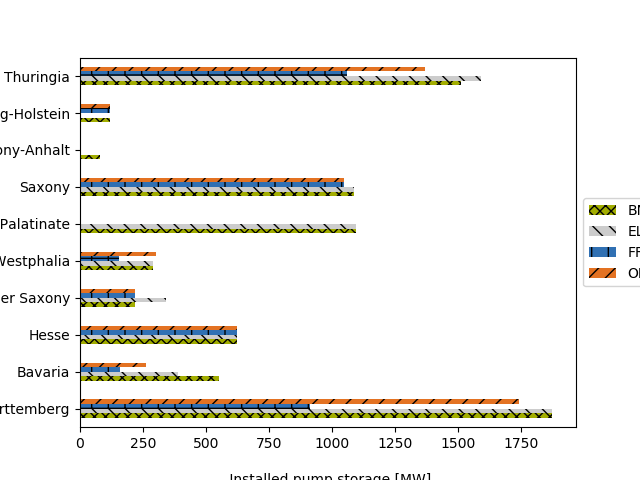

In [14]:
# Define colors
tumblue = define.tumblue
tumgreen = define.tumgreen
tumorange = define.tumorange
tumlightgrey = define.tumlightgrey

# Set hatch color
plt.rcParams['hatch.color'] = 'black'

# Create dataframe
sto_comp = pd.concat([sto_bnet, sto_elmo, sto_fre, sto_opsd], axis=1) 

# Adapt dataframe
sto_comp.rename(columns={'Pump storage':'OPSD', 'Capacity':'FRESNA', 
                         'cap':'ELMOD-DE', 'Kapazität':'BNetzA'},
                inplace=True)

# Plot dataframe
ax = sto_comp.plot(kind='barh', legend='reverse', 
                   color={tumblue, tumorange, tumlightgrey, tumgreen})

# Add hatches
bars = ax.patches
patterns =('xxx', '\\\\','+', '//')
hatches = [p for p in patterns for i in range(len(sto_comp))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

# Add legend
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel('\n Installed pump storage [MW]')

# Define output
sto_file_comp_out = 'Comparsion of storage constraints'
sto_path_comp_out = os.path.join(folder_out, agg_subfolder, sto_subfolder, 
                                 sto_file_comp_out+dt_png)

# Save plot to file
plt.gcf().savefig(sto_path_comp_out, dpi=600, bbox_inches='tight')

***

### Transmission Grid Aggregation<a id='transmisson'></a>
<div style="text-align: right"> Back to [beginning](#start).</div>

Here, the German transmission grid based on data from 
- [OpenGridMap](http://opengridmap.com/) ([download at github](https://github.com/OpenGridMap/transnet-models)) \[License: [CC BY 3.0 IGO](https://creativecommons.org/licenses/by/3.0/igo/)\],
- [SciGrid](http://www.scigrid.de/pages/downloads.html) \[License: [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0)\] - or
- [GridKit](https://www.scigrid.de/posts/2016-Mai-11_release-of-gridkit-10-toolkit.html) ([download data](https://zenodo.org/record/47317#.WliH4DAiEuU)) \[License: [MIT License](https://github.com/bdw/GridKit/blob/master/LICENSE)\]

can be aggregated. The desired source can be choosen in the 'Input' cell. 

This part can be separated in to four subparts: collecting data, calculating phyiscal values, adpating data and visualizing the resulting net. The calculation algorithm is based on the Bachelor's thesis "Automatic transmission grid aggregation for Bavaria", supervised by Magdalena Dorfner at TUM. In each part a short introduction is given.

To run this notebook correctly run the cells from first to last.

#### Import

In [15]:
from geopy.geocoders import Nominatim
from urllib.request import Request
import geopy.distance
import re
import math
geo = Nominatim()

#### Input
At first, the input files are defined. Also, a set of German states is defined. The raw data are read from csv-files to dataframes. It's split by the sources, due to their different structures.

In [16]:
# Define Input
tra_subfolder = 'Transmission'

#Source either 'GridKit', 'OpenGridMap' or 'SciGrid'
tra_source = 'SciGrid' 

# Read data from csv-files 
tra_nodes = pd.DataFrame()
tra_lines = pd.DataFrame()

# Read in data differing between sources
if tra_source == 'GridKit':
    # Read in nodes
    tra_file_in_nodes = 'gridkit_highvoltage_de_vertices'
    tra_path_in_nodes = os.path.join(folder_in, agg_subfolder, tra_subfolder, 
                                     tra_source, tra_file_in_nodes+dt_csv)
    # Used columns:
    # 0: v_id - identify each node
    # 1: lon - longitude of each node
    # 2: lat - latitude of each node
    help_df = pd.read_csv(tra_path_in_nodes, usecols=[0,1,2,3,4,5,6,7], index_col=0)
    tra_nodes = pd.concat([tra_nodes,help_df])

    #Read in lines
    tra_file_in_lines = 'gridkit_highvoltage_de_links'
    tra_path_in_lines = os.path.join(folder_in, agg_subfolder, tra_subfolder, 
                                     tra_source, tra_file_in_lines+dt_csv)
    help_df = pd.read_csv(tra_path_in_lines, index_col=[0,1,2])
    tra_lines = pd.concat([tra_lines,help_df])

if tra_source ==  'OpenGridMap':    
    # Adapt states to source nomenclature
    for st in states_de:
        if st == 'Baden-Württemberg':
            st = 'Baden-Wuerttemberg'
        if st == 'Thüringen':
            st = 'Thueringen'
        if st == 'Offshore':
            break
        
        # Read in nodes
        tra_file_in_nodes = 'csv_nodes'
        tra_path_in_nodes = os.path.join(folder_in, agg_subfolder, tra_subfolder, 
                                         tra_source, st, tra_file_in_nodes+dt_csv)
        # Used columns:
        # 0: n_id - identify each node
        # 1: longitude - longitude of each node
        # 2: latitude - latitude of each node
        help_df = pd.read_csv(tra_path_in_nodes, usecols=[0,1,2], index_col=0)
        tra_nodes = pd.concat([tra_nodes,help_df])
        
        #Read in lines
        tra_file_in_lines = 'csv_lines'
        tra_path_in_lines = os.path.join(folder_in, agg_subfolder, tra_subfolder, 
                                         tra_source, st, tra_file_in_lines+dt_csv)
        help_df = pd.read_csv(tra_path_in_lines, index_col=[0,1,2])
        tra_lines = pd.concat([tra_lines,help_df])

if tra_source == 'SciGrid':
    # Define special data type
    tra_dt = '.csvdata'
    
    # Read in nodes
    tra_file_in_nodes = 'sci_vertices'
    tra_path_in_nodes = os.path.join(folder_in, agg_subfolder, tra_subfolder, 
                                     tra_source, tra_file_in_nodes+tra_dt)
    # Used columns:
    # 0: v_id - identify each node
    # 1: lon - longitude of each node
    # 2: lat - latitude of each node
    help_df = pd.read_csv(tra_path_in_nodes, usecols=[0,1,2], index_col=0)
    tra_nodes = pd.concat([tra_nodes,help_df])

    #Read in lines
    tra_file_in_lines = 'sci_links'
    tra_path_in_lines = os.path.join(folder_in, agg_subfolder, tra_subfolder, 
                                     tra_source, tra_file_in_lines+tra_dt)
    help_df = pd.read_csv(tra_path_in_lines, index_col=[0,1,2])
    tra_lines = pd.concat([tra_lines,help_df])

#### Requesting Geographical Data
Each node will be assigned to a state. For this purpose the geograhpical location is sent to [OpenStreetMap](https://wiki.openstreetmap.org/wiki/Nominatim) and the address is recieved. This process takes quiet a long time. Because of that, it is checked in the first line, if already a file with addresses exists.
If not, the address for all nodes is retrieved. As the user gets banned from the server after too many request in a short time, some breaks are put in the algorithm. 

In [17]:
# Construct address and state for each node
try:
    # If data is already existing, read data from file
    tra_file_in_nodes = 'Knoten'+tra_source
    tra_subfolder_retr = 'Transmission data retrieval'
    tra_path_in_nodes = os.path.join(folder_in, agg_subfolder, tra_subfolder, 
                                     tra_subfolder_retr, tra_file_in_nodes+dt_xlsx)
    tra_nodes = pd.read_excel(tra_path_in_nodes, index_col=0)

except:
    # Add columns for address and region
    tra_nodes['address'] = np.nan
    tra_nodes['state'] = np.nan
    tra_nodes = tra_nodes.groupby(tra_nodes.index).first()
    counter = 0
    counter2 = 0
    
    # Request address from nominatim for all nodes
    while counter < len(tra_nodes.index):
        lv = tra_nodes.index[counter]
        
        # 15 minutes break after 1000 requests
        if counter2 == 1000:
            print('Recieved first 1000 adresses. Sleeping for 15 minutes, to avoid getting banned. Startet sleeping: '+str(datetime.now()))
            time.sleep(900)
            counter2 = 0
            
        # Get geodata from different sources
        if tra_source == 'OpenGridMap':
            lat, lon = tra_nodes.loc[lv, 'latitude'], tra_nodes.longitude[lv]
        if tra_source == 'GridKit' or tra_source == 'SciGrid':
            lat, lon = tra_nodes.lat[lv], tra_nodes.lon[lv]
            
        # Try request address
        try:
            cord = geo.reverse('%s, %s' % (lat, lon), timeout=10)
            counter = counter+1
            counter2 = counter2+1
            
        # If request fails, wait one hour to overcome ban
        # and save already retrieved values to excel
        except:
            print('Nominatim Error 429: Too many requests! Have to wait one hour. Startet sleeping: '+str(datetime.now()))
            tra_file_out_nodes = 'nodes_at_'+tra_source+str(counter)
            tra_path_out_nodes = os.path.join(folder_in, agg_subfolder, tra_subfolder,
                                              tra_subfolder_retr, 
                                              tra_file_out_nodes+dt_xlsx)
            tra_nodes.to_excel(tra_path_out_nodes)
            time.sleep(3600)
            continue
            
        # Assign address and state to node
        address = cord.address
        state = np.nan
        asplit = address.split(', ')
        for st in states:
            if st in address:
                state = st
                break
            if 'EEZ' in address:
                state = 'Offshore'
                break
            elif st == 'Thüringen' and state!=st:
                state = 'Ausland'
        tra_nodes.loc[lv, 'address'] = address
        tra_nodes.loc[lv, 'state'] = state

    # Save recieved addresses
    tra_file_out_nodes = 'Knoten'+tra_source
    tra_path_out_nodes = os.path.join(folder_in, agg_subfolder, tra_subfolder,
                                      tra_subfolder_retr, tra_file_out_nodes+dt_xlsx)
    tra_nodes.to_excel(tra_path_out_nodes)

tra_nodes.head(5)


,lon,lat,typ,voltage,frequency,name,operator,address,state
v_id,,,,,,,,,
1,9.522576,52.360409,substation,220000;110000,50,Hannover/West,TenneT;EON_Netz,"K 251, Seelze, Region Hannover, Niedersachsen,...",Niedersachsen
2,9.113210,52.543853,substation,220000,50,Umspannwerk Kraftwerk Robert Frank,TenneT,"Süllhof, Landesbergen, Samtgemeinde Mittelwese...",Niedersachsen
3,9.389745,52.026313,substation,380000;110000,50,UW Grohnde 380 kV / 110 kV,TenneT,"Eigenbedarfsgebäude, Reherstraße, Emmerthal, K...",Niedersachsen
4,9.125266,52.538264,substation,380000;220000,50,Landesbergen,TenneT TSO GmbH,"In den Büschen, Hahnenberg, Landesbergen, Samt...",Niedersachsen
5,10.366275,52.284647,substation,380000;220000,50,Wahle,TenneT,"Wahle, Vechelde, Landkreis Peine, Niedersachse...",Niedersachsen


#### Editing
Each transmission line is connected to the address of their starting and ending node. As only the german net is considered, all lines, which starting or ending node has no german address, are neglected. In `tra_statelinks` all transmission lines, which connect two states, are collected.

After collecting all transmission lines connecting two states in the dataframe `tra_statelinks`, the parameters reactance per km (`x_ohmkm`), susceptance factor per kilometer (`c_nfkm`) and the length in meter (`length_m`) are added. For lines without those values, the mean value of the other lines normalized by length is set. 

In [18]:
# Filtering lines which start and end at a node with a state
tra_indices = tra_nodes.loc[tra_nodes.state==tra_nodes.state].index

if tra_source == 'GridKit' or tra_source == 'SciGrid':
    help_lines = tra_lines.loc[((tra_lines.index.get_level_values('v_id_1').isin(tra_indices))) &
                               ((tra_lines.index.get_level_values('v_id_2').isin(tra_indices)))]

if tra_source == 'OpenGridMap':
    help_lines = tra_lines.loc[((tra_lines.index.get_level_values('n_id_start').isin(tra_indices))) &
                               ((tra_lines.index.get_level_values('n_id_end').isin(tra_indices)))]

# Create additonal columns for calcualtion
help_index = pd.MultiIndex.from_tuples(help_lines.index.values, names=['id', 'v1', 'v2'])
help_df = pd.DataFrame(index=help_index, columns=['cap', 'reactance', 'shuntcap',
                                                  'susceptance', 'capfactor', 'sil',
                                                  'vin', 'vout', 'length'])

# Create dataframe with all links between nodes
tra_links = pd.concat([help_df, help_lines.loc[:, 'voltage': 'frequency']], axis=1)

# Save links to excel
tra_file_out_links = 'Links'+tra_source
tra_path_out_links = os.path.join(folder_in, agg_subfolder, tra_subfolder, 
                                  tra_subfolder_retr, tra_file_out_links+dt_xlsx)
tra_nodes.to_excel(tra_path_out_links)

# Set states of nodes to index
for (lv1, lv2, lv3) in help_index.values:
    ind = (lv1, lv2, lv3)
    tra_links.vin.loc[ind] = tra_nodes.state[lv2]
    tra_links.vout.loc[ind] = tra_nodes.state[lv3]

# Finding all links between states
tra_statelinks = tra_links.loc[tra_links.vin!=tra_links.vout]

# Filter lower voltage lines
tra_statelinks = tra_statelinks.loc[(tra_statelinks.voltage!=110000)]

# Assign values to new added columns of dataframe
if tra_source == 'GridKit':
    # For voltage cells with more than one value first is taken 
    for lv in tra_statelinks.index:
        if tra_statelinks.voltage[lv].dtype == 'str':
            string = tra_statelinks.voltage[lv]
            integer = string[0:5]
            tra_statelinks.voltage[lv] = integer
    tra_statelinks.reactance = help_lines.loc[tra_statelinks.index].x_ohmkm
    tra_statelinks.shuntcap = help_lines.loc[tra_statelinks.index].c_nfkm
    tra_statelinks.length = help_lines.loc[tra_statelinks.index].length_m
    
if tra_source == 'SciGrid':
    tra_statelinks.reactance = help_lines.loc[tra_statelinks.index].x_ohmkm
    tra_statelinks.shuntcap = help_lines.loc[tra_statelinks.index].c_nfkm
    tra_statelinks.length = help_lines.loc[tra_statelinks.index].length_m
    
if tra_source == 'OpenGridMap':
    tra_statelinks.reactance = help_lines.loc[tra_statelinks.index].x_ohm_km
    tra_statelinks.shuntcap = help_lines.loc[tra_statelinks.index].c_nf_km
    tra_statelinks.length = help_lines.loc[tra_statelinks.index].length_m

# List of possible voltages
tra_voltages = [220000, 300000, 380000, 400000, 450000]

# Scaling reactance and shuntcap to length to calculate mean values
tra_statelinks.reactance.loc[tra_statelinks.reactance.notnull()] = tra_statelinks.reactance.loc[
    tra_statelinks.reactance.notnull()]/tra_statelinks.length
tra_statelinks.shuntcap.loc[tra_statelinks.shuntcap.notnull()] = tra_statelinks.shuntcap.loc[
    tra_statelinks.shuntcap.notnull()]/tra_statelinks.length

# Set mean values instead of nan in reactance and shuntcap column
for vol in tra_voltages:  
    tra_statelinks.reactance.loc[tra_statelinks.reactance.isnull() 
                                 & (tra_statelinks.voltage==vol)] = tra_statelinks.loc[
        tra_statelinks.reactance.notnull() & (tra_statelinks.voltage==vol)].reactance.mean()
    tra_statelinks.shuntcap.loc[tra_statelinks.shuntcap.isnull() 
                                & (tra_statelinks.voltage==vol)] = tra_statelinks.loc[
        tra_statelinks.shuntcap.notnull() & (tra_statelinks.voltage==vol)].shuntcap.mean()

# Undo scaling of reactance and shuntcap to length
tra_statelinks.reactance.loc[tra_statelinks.reactance.notnull()] = tra_statelinks.reactance.loc[
    tra_statelinks.reactance.notnull()]*tra_statelinks.length
tra_statelinks.shuntcap.loc[tra_statelinks.shuntcap.notnull()] = tra_statelinks.shuntcap.loc[
    tra_statelinks.shuntcap.notnull()]*tra_statelinks.length
    
tra_statelinks.head(5)

,,,cap,reactance,shuntcap,susceptance,capfactor,sil,vin,vout,length,voltage,cables,wires,frequency
id,v1,v2,,,,,,,,,,,,,
5,8,9,NaN,0.125000,27.400000,NaN,NaN,NaN,Schleswig-Holstein,Niedersachsen,28172,380000,6.0,4.0,50.0
12,17,18,NaN,0.333333,10.275000,NaN,NaN,NaN,Berlin,Mecklenburg-Vorpommern,200169,380000,3.0,3.0,50.0
13,17,12,NaN,0.333333,10.275000,NaN,NaN,NaN,Berlin,Brandenburg,24249,380000,3.0,3.0,50.0
17,20,21,NaN,0.500000,6.850000,NaN,NaN,NaN,Schleswig-Holstein,Hamburg,31297,380000,3.0,2.0,50.0
23,23,27,NaN,0.474685,16.972706,NaN,NaN,NaN,Schleswig-Holstein,Niedersachsen,41967,220000,3.0,NaN,NaN


***
#### Calculation of physical value
The capacity of each line is calculated. The calculation algorithm is based on the Bachelor's thesis "Automatic transmission grid aggregation for Bavaria", supervised by Magdalena Dorfner at TUM.

For a better estimation of loadability $c$ the St-Clair-Curve is fitted by inspection. The recieved function is used to estimate $c$ for each line.

In [19]:
# Calculcate shunt susceptance
tra_statelinks.susceptance = 2* math.pi* 50* tra_statelinks.shuntcap / (10**3)

# Function to fill the values for the loadability c 
def cfactor(x):
    c = 5.8113 - 0.851647*math.log(x/1000)
    return c 

# Filling the values for the loadability c 
for lv in tra_statelinks.index:
    tra_statelinks.capfactor[lv] = cfactor(tra_statelinks.loc[lv, 'length'])

# Calculate surge impedance loading (SIL)
tra_statelinks.sil = (tra_statelinks.voltage / (10**3))**2 * (tra_statelinks.susceptance /
                                                      ((10**6) * tra_statelinks.reactance)) ** (1/2)

# Calculates capacity
tra_statelinks.cap = tra_statelinks.sil * tra_statelinks.capfactor

# Check for thermal limits
tra_thermal_limits = {220000: 400, 380000: 1800}
tra_statelinks.cap.loc[(tra_statelinks.cap > 
                        tra_statelinks.voltage.map(tra_thermal_limits)* tra_statelinks.cables / 3)
                       & (tra_statelinks.length < 80000)] = tra_statelinks.voltage.map(
                                                                tra_thermal_limits)

# Finished calculation
tra_statelinks.head(5)

,,,cap,reactance,shuntcap,susceptance,capfactor,sil,vin,vout,length,voltage,cables,wires,frequency
id,v1,v2,,,,,,,,,,,,,
5,8,9,3556.8,0.125000,27.400000,8.607964,2.96822,1198.291295,Schleswig-Holstein,Niedersachsen,28172,380000,6.0,4.0,50.0
12,17,18,583.396,0.333333,10.275000,3.227986,1.29828,449.359460,Berlin,Mecklenburg-Vorpommern,200169,380000,3.0,3.0,50.0
13,17,12,1391.19,0.333333,10.275000,3.227986,3.09593,449.359460,Berlin,Brandenburg,24249,380000,3.0,3.0,50.0
17,20,21,862.361,0.500000,6.850000,2.151991,2.87863,299.572824,Schleswig-Holstein,Hamburg,31297,380000,3.0,2.0,50.0
23,23,27,400,0.474685,16.972706,5.332133,2.62879,162.215693,Schleswig-Holstein,Niedersachsen,41967,220000,3.0,NaN,NaN


#### Adapt data

All lines between the same states are collected in one connection. Additionally, a column for median length between states and investmens costs for new lines between these states is added. Specific cost for building new lines (investment costs) are assumed to be $2000\frac{€}{MW*km}$. Furthermore, specific cost for maintaining lines (fixed costs) are assumed to be $1.1\frac{€}{MW*km}$. Those values are taken from the bachelor's thesis "Technical, Economic and Ecological Analysis of Conventional and Innovative Power Transmission Technologies" of Kais Siala, which was written at TUM. Finally, the output structure is converted to the input file structure of urbs. 

In [20]:
# Exchange vin and vout in case of wrong order
help_bool = tra_statelinks.vin > tra_statelinks.vout
help_df = tra_statelinks.vout.loc[help_bool]
tra_statelinks.vout.loc[help_bool] = tra_statelinks.vin.loc[help_bool]
tra_statelinks.vin.loc[help_bool] = help_df
      
# Function for reducing statelinks to one for each state-pair
def aggregate_lines(df):
    lv = 0
    while lv < len(df)-1:
        # check for same in and output nodes
        if (df.iloc[lv,6] == df.iloc[lv+1,6]) & (df.iloc[lv,7] == df.iloc[lv+1,7]):
            # add capacities
            df.iloc[lv,0] = df.iloc[lv,0] + df.iloc[lv+1,0]
            df = df.drop(df.index[lv+1])
        else:
            lv +=1
            
    df_final = df
    return df_final

# Sort and aggreaget transmission lines
tra_statelinks = tra_statelinks.sort_values(['vin', 'vout'])
try:
    tra_statelinks = aggregate_lines(tra_statelinks.reset_index().loc[:, 'cap':'length'])
except:
    pass

# Read in coordinates of the geographical center of each state
tra_coordinates = define.coordinates_states_de
tra_distances = pd.DataFrame(index=tra_coordinates, columns=tra_coordinates)

# Calculate median length between states
for key1 in tra_coordinates:
    for key2 in tra_coordinates:
        help_distance = geopy.distance.vincenty(tra_coordinates[key1], tra_coordinates[key2]).km
        tra_distances[key1][key2] = help_distance

# Set distance to length of lines
for st1 in tra_statelinks['vin']:
    for st2 in tra_statelinks['vout']:
        try:
            tra_statelinks.length[(tra_statelinks.vin == st1) 
                           & (tra_statelinks.vout == st2)] = tra_distances[st1][st2]
        except:
            pass

# Include column for investment costs
tra_statelinks['inv-cost'] = tra_statelinks['length']*2000

# Include column for fix costs
tra_statelinks['fix-cost'] = tra_statelinks['length']*1.1

# Adapting to input file structure of urbs
tra_statelinks = tra_statelinks[['vin','vout','inv-cost','fix-cost','cap', 'length']]
tra_statelinks = tra_statelinks[tra_statelinks.vin != 'Ausland']
tra_statelinks.rename(states_translation, inplace=True)

tra_statelinks.head()

,vin,vout,inv-cost,fix-cost,cap,length
48,Baden-Württemberg,Bayern,333375.154134,183.356335,5393.68,166.687577
53,Baden-Württemberg,Hessen,495933.658716,272.763512,2763.71,247.966829
57,Baden-Württemberg,Rheinland-Pfalz,425807.867094,234.194327,593.599,212.903934
58,Baden-Württemberg,Saarland,372365.433199,204.800988,852.394,186.182717
59,Bayern,Hessen,557899.320338,306.844626,6374.64,278.949660


#### Output


In [21]:
# Define output
tra_file_out = 'German Transmission Grid '+tra_source
tra_path_out = os.path.join(folder_out, agg_subfolder, tra_subfolder,
                            tra_file_out+dt_xlsx)

# Save file to excel
tra_statelinks.to_excel(tra_path_out)

#### Visualization
This part can be executed to show the transmission lines on a map of Germany.

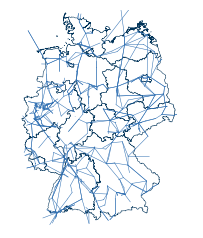

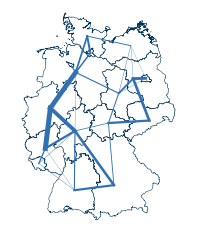

In [22]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
%matplotlib inline

# Read in shape of Germany
tra_subfolder_shapes = 'Shapes'
tra_subfolder_vis = 'Visualization'
tra_file_shape = 'DEU_adm1.shp'
tra_path_shape = os.path.join(folder_in, tra_subfolder_vis, tra_subfolder_shapes, tra_file_shape)
tra_shape_ger = list(shpreader.Reader(tra_path_shape).geometries())

# Import coordinates of the geographical center of each state
coordinates = define.coordinates_states_de

# Import colors
tumdarkblue = define.tumdarkblue
tumblue = define.tumblue
tumwhite = define.tumwhite

# Define output
data_typ_png = '.png'
tra_file_out_plot_raw = 'germany-lines-raw-'+tra_source
tra_path_out_plot_raw = os.path.join(folder_out, tra_subfolder_vis, tra_file_out_plot_raw+dt_png)
tra_file_out_plot_agg = 'germany-lines-aggregated-'+tra_source
tra_path_out_plot_agg = os.path.join(folder_out, tra_subfolder_vis, tra_file_out_plot_agg+dt_png)

# Create figure for raw transmission lines plot
tra_fig_raw = plt.figure()

# Generate shape of Germany with states
ax = plt.axes(projection=ccrs.EuroPP(), frameon=False)
ax.add_geometries(tra_shape_ger, ccrs.PlateCarree(),
              edgecolor=tumdarkblue, facecolor=tumwhite, linewidth=.5)
ax.set_extent([5.5, 15.5, 47, 55], ccrs.PlateCarree())

# Add all lines to plot
for (lv, lv1, lv2) in tra_links.index.get_values():        
    try:
        if tra_source == 'OpenGridMap':
            plt.plot([tra_nodes.loc[lv1].longitude, tra_nodes.loc[lv2].longitude], 
                     [tra_nodes.loc[lv1].latitude, tra_nodes.loc[lv2].latitude],
                     color=tumblue, transform=ccrs.Geodetic(), linewidth=.5)

        if tra_source == 'SciGrid' or tra_source == 'GridKit':
            plt.plot([tra_nodes.loc[lv1].lon, tra_nodes.loc[lv2].lon], 
                     [tra_nodes.loc[lv1].lat, tra_nodes.loc[lv2].lat],
                     color=tumblue, transform=ccrs.Geodetic(), linewidth=.5)
    except:
        pass
    
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

# Save plot to file
plt.gcf().savefig(tra_path_out_plot_raw, bbox_inches='tight', dpi=600)

# Create figure for aggregated transmission lines plot
tra_fig_agg = plt.figure()

# Generate shape of Germany with states
ax = plt.axes(projection=ccrs.EuroPP(), frameon=False)
ax.add_geometries(tra_shape_ger, ccrs.PlateCarree(),
              edgecolor=tumdarkblue, facecolor=tumwhite, linewidth=.5)
ax.set_extent([5.5, 15.5, 47, 55], ccrs.PlateCarree())

# Add aggregated lines weighted with capacity to plot
for lv in tra_statelinks[['vin', 'vout']].itertuples():
    # Weighting line with capacity
    plt.plot([tra_coordinates[lv.vin][1], tra_coordinates[lv.vout][1]], 
                     [coordinates[lv.vin][0], coordinates[lv.vout][0]],
                     color=tumblue, transform=ccrs.Geodetic(), 
                     linewidth=tra_statelinks.loc[lv[0],'cap']/2500)

ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

# Save plot to file
plt.gcf().savefig(tra_path_out_plot_agg, bbox_inches='tight', dpi=600)

***
***

## Timeseries <a id='timeseries'></a> 
<div style="text-align: right"> Back to [beginning](#start).</div>

***

### Demand Timeseries Generation<a id='demand'></a> 
<div style="text-align: right"> Back to [beginning](#start).</div>

In this part the German demand timeseries is generated out of the load timeseries from the [Open Power System Data Platform](https://data.open-power-system-data.org/time_series/) (primary data from various sources, for a complete list see URL). Their load timeseries is extracted from the ENTSO-E Transparency Platform. Also some data from the [Länderarbeitskreis Energiebilanzen](http://www.lak-energiebilanzen.de/) is included in the generating process and may be used with citation.

#### Input

Input sources are defined and data is read in. In `dem_ls` the overall load of germany is saved. In the other loadseries the load of each TSO is saved. In `dem_load_states` the production of power plants in germany separated by each state is saved.

In [23]:
# Year of demand
dem_year = '2015'

# Define input
dem_file_in_OPSD = 'OPSD-DE-2015-time_series_60min_all'
dem_file_in_LAK = 'Bruttostromerzeugung 2014 konventionell'
dem_path_in_OPSD = os.path.join(folder_in, ts_subfolder,  dem_file_in_OPSD+dt_csv)
dem_path_in_LAK = os.path.join(folder_in, ts_subfolder, dem_file_in_LAK+dt_csv)


In [24]:
# Load timeseries for germany
# Used columns for dem_ls:
# 0: utc_timestamp - timestep
# 3: DE_load_new - load of germany
dem_ls = pd.read_csv(dem_path_in_OPSD, sep=',', usecols=[0,3], index_col=0, 
                         parse_dates=[0], decimal='.', names=['Time', 'load'], 
                         skiprows=1)

# Load timeseries for 50Hertz region
# Used columns for dem_ls_50h:
# 0: utc_timestamp - timestep
# 5: DE_50h_load_new - load of 50Hertz region
dem_ls_50h = pd.read_csv(dem_path_in_OPSD, sep=',', usecols=[0,5], index_col=0,
                             parse_dates=[0], decimal='.', names=['Time', 'load'],
                             skiprows=1)

# Load timeseries for Amprion region
# Used columns for dem_ls_amp:
# 0: utc_timestamp - timestep
# 6: DE_amprion_load_new - load of Amprion region
dem_ls_amp = pd.read_csv(dem_path_in_OPSD, sep=',', usecols=[0,6], index_col=0,
                             parse_dates=[0], decimal='.', names=['Time', 'load'],
                             skiprows=1)

# Load timeseries for Tennet region
# Used columns for dem_ls_ten:
# 0: utc_timestamp - timestep
# 7: DE_tennet_load_new - load of TenneT region
dem_ls_ten = pd.read_csv(dem_path_in_OPSD, sep=',', usecols=[0,7], index_col=0,
                             parse_dates=[0], decimal='.', names=['Time', 'load'],
                             skiprows=1)

# Load timeseries for TransnetBW region
# Used columns for dem_ls_tra:
# 0: utc_timestamp - timestep
# 8: DE_transnetbw_load_new - load of TransnetBW region
dem_ls_tra = pd.read_csv(dem_path_in_OPSD, sep=',', usecols=[0,8], index_col=0,
                             parse_dates=[0], decimal='.', names=['Time', 'load'],
                             skiprows=1)

# Demand for each state with unit adjustment
# Used columns for dem_load_states:
# 0: Bundesland - state
# 3: Insgesamt - load per state
dem_load_states = pd.read_csv(dem_path_in_LAK, sep=';', index_col=0, usecols=[0,3], 
                      skiprows=2, skipfooter=11, engine='python')
dem_load_states = dem_load_states.T * 1000
dem_load_states.head()

,Baden-Württemberg,Bayern,Berlin,Brandenburg,Bremen,Hamburg,Hessen,Mecklenburg-Vorpommern,Niedersachsen,Nordrhein-Westfalen,Rheinland-Pfalz,Saarland,Sachsen,Sachsen-Anhalt,Schleswig-Holstein,Thüringen
Insgesamt,60857000,88289000,7817000,54353000,6940000,4107000,13103000,12298000,72640000,175402000,17878000,12147000,42853000,22773000,28677000,8439000


#### Calculation

To consider production and transmission losses a factor is calculated. It is:
<center>
$1- \frac{(overall\ production) - (total\ transmitted\ load\ of\ all\ TSOs)}{(overall\ production)}$
</center>


With the loadsum of each state, the loss factor and its related TSO-loadseries, the load for each state per hour is calculated. The quotient of the loadsum of a state and the sum of the loadseries of each TSO should give an factor for the share each state has in the load. For states with more than one TSO, the portion of the TSO for this state is made by a rough approximation. For this purpose, with help of a German TSO map, the portion per TSO and state were estimated by inspection.

<center>$\left(load\ of\ TSO\ region\right) \cdot \left(\frac{load\ of\ state\ over\ one\ year}{load\ of\ TSO\ region\ over\ one\ year} \right) \cdot \left(factor\ for\ losses\right) $</center>

In [25]:
# Creating load dataframe
dem_ts_load = pd.DataFrame()

# Factor for production and transmission losses
factor = 1 -(dem_load_states.sum(axis=1)-dem_ls.load.sum())/dem_load_states.sum(axis=1)

# Calculate load timeseries for each state
for lv in dem_load_states:
    
    # TransnetBW region
    if dem_load_states[lv].name == 'Baden-Württemberg':
        help_df = dem_ls_tra.load*(dem_load_states[lv].values[0]/dem_ls_tra.load.sum())*factor[0]
        help_df = help_df.rename(lv)
        
    # Tennet Region    
    elif ((dem_load_states[lv].name == 'Bremen') 
          or (dem_load_states[lv].name== 'Niedersachsen') 
          or (dem_load_states[lv].name == 'Schleswig-Holstein')):
        help_df = dem_ls_ten.load*(dem_load_states[lv].values[0]/dem_ls_ten.load.sum())*factor[0]
        help_df = help_df.rename(lv)
        
    # 50Hertz region    
    elif ((dem_load_states[lv].name == 'Berlin') 
          or (dem_load_states[lv].name == 'Brandenburg') 
          or (dem_load_states[lv].name == 'Hamburg') 
          or (dem_load_states[lv].name == 'Mecklenburg-Vorpommern') 
          or (dem_load_states[lv].name == 'Sachsen') 
          or (dem_load_states[lv].name == 'Sachsen-Anhalt') 
          or (dem_load_states[lv].name == 'Thüringen')):
        help_df = dem_ls_50h.load*(dem_load_states[lv].values[0]/dem_ls_50h.load.sum())*factor[0]
        help_df = help_df.rename(lv)
        
    # Amprion region     
    elif ((dem_load_states[lv].name == 'Rheinland-Pfalz') 
          or (dem_load_states[lv].name == 'Saarland')):
        help_df = dem_ls_amp.load*(dem_load_states[lv].values[0]/dem_ls_amp.load.sum())*factor[0]
        help_df = help_df.rename(lv)
    
    # States with more than one TSO   
    elif dem_load_states[lv].name == 'Bayern':
        help_df = ((0.15*dem_ls_amp.load+0.85*dem_ls_ten.load)
                   *(dem_load_states[lv].values[0]/(0.15*dem_ls_amp.load.sum()+0.85*dem_ls_ten.load.sum()))
                   *factor[0])
        help_df = help_df.rename(lv)
        
    elif dem_load_states[lv].name == 'Hessen':
        help_df = ((0.3*dem_ls_amp.load+0.7*dem_ls_ten.load)
                   *(dem_load_states[lv].values[0]/(0.3*dem_ls_amp.load.sum()+0.7*dem_ls_ten.load.sum()))
                   *factor[0])
        help_df = help_df.rename(lv)
        
    elif dem_load_states[lv].name == 'Nordrhein-Westfalen':
        help_df = ((0.9*dem_ls_amp.load+0.1*dem_ls_ten.load)
                   *(dem_load_states[lv].values[0]/(0.9*dem_ls_amp.load.sum()+0.1*dem_ls_ten.load.sum()))
                   *factor[0])
        help_df = help_df.rename(lv)
        
    else:
        print(dem_load_states[lv].name)
        
    dem_ts_load = pd.concat([dem_ts_load,help_df], axis=1)

# Translate states and add .Elec to state name 
dem_ts_load = dem_ts_load.rename(columns=states_translation)
dem_ts_load = dem_ts_load.add_suffix('.Elec')

# Create rows of zeros to adjust output to the input file of urbs
t = pd.Timestamp('2000-01-01 00:00:00')
zero_row = pd.DataFrame({'Time': [t]})

for lv in dem_load_states:
    zero_row.insert(+1,column=lv,value=0)
    
zero_row = zero_row.rename(columns=states_translation)
zero_row.set_index(['Time'], inplace=True)
zero_row = zero_row.add_suffix('.Elec')

# Adding row of zeros
dem_ts_load = pd.concat([dem_ts_load, zero_row])

dem_ts_load = dem_ts_load.sort_index()
dem_ts_load.head()

,Baden-Württemberg.Elec,Bavaria.Elec,Berlin.Elec,Brandenburg.Elec,Bremen.Elec,Hamburg.Elec,Hesse.Elec,Lower Saxony.Elec,Mecklenburg-Vorpommern.Elec,North Rhine-Westphalia.Elec,Rhineland-Palatinate.Elec,Saarland.Elec,Saxony-Anhalt.Elec,Saxony.Elec,Schleswig-Holstein.Elec,Thuringia.Elec
Time,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-01 00:00:00,3981.742910,5819.029074,500.090545,3477.219061,461.256773,262.744259,856.753909,4827.909505,786.761357,11149.276623,1131.612119,768.860745,1456.896762,2741.509547,1905.974131,539.882834
2015-01-01 01:00:00,3802.351451,5566.511123,506.351688,3520.753905,439.494130,266.033821,822.682723,4600.122999,796.611623,10852.040833,1103.695893,749.893389,1475.137134,2775.833295,1816.048007,546.642176
2015-01-01 02:00:00,3667.060393,5353.715338,516.471441,3591.118361,421.798946,271.350673,792.824807,4414.910010,812.532401,10532.740801,1072.355277,728.599371,1504.618667,2831.310049,1742.929163,557.567160
2015-01-01 03:00:00,3636.414353,5226.093662,536.128516,3727.797520,411.612917,281.678369,774.158969,4308.294282,843.457655,10295.680214,1048.384545,712.312735,1561.884954,2939.070652,1700.839140,578.788352


#### Output


In [26]:
# Define output
dem_file_out = 'German Electricity Demand Timeseries '+dem_year
dem_path_out = os.path.join(folder_out, ts_subfolder, dem_file_out+dt_xlsx)

# Save data to excel file
dem_ts_load.to_excel(dem_path_out)

***

### Supply Intermittent Timeseries Generation<a id='supim'></a> 
<div style="text-align: right"> Back to [beginning](#start).</div>

In this part the supply intermittent timeseries is created. 

Firstly, the solar and wind timeseries for Germany is generated with data from [Renewables.ninja](https://www.renewables.ninja/) \[License: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)\]. To access the database, an account and by this a token has to be created on their homepage. The tokan has to be included at `sup_sw_token`.

Secondly, the German hydro timeseries is generated with data from [Pegelonline](https://www.pegelonline.wsv.de/gast/start) (data can be requested at URL). Also data from [Länderarbeitskreis Energiebilanzen](http://www.lak-energiebilanzen.de/), which may be used with correct citation, and from the 'German Power Plants' part is taken to get data for the annual hydro electricity production and capacity.

In [27]:
import requests
import time

#### Input
Information, which are necessary for the request, are defined.

In [28]:
# Year of data (data from Pegelonline is from 2013 to 2015)
sup_year = '2015'

# Data to access Renewables.ninja
sup_solar_url = 'https://www.renewables.ninja/api/data/pv'
sup_wind_url = 'https://www.renewables.ninja/api/data/wind'
sup_sw_token = #Insert your token here
sup_sw_req = requests.session()
sup_sw_req.headers = {'Authorization': 'Token ' + sup_sw_token}


# Define input for hydro data
sup_hydro_subfolder = 'Hydro'
sup_hydro_file_in_prod = 'Bruttostromerzeugung 2014 erneuerbar'
sup_hydro_file_in_cap = 'German Power Plant Capacities'
sup_hydro_path_in_prod = os.path.join(folder_in, ts_subfolder, 
                                      sup_hydro_file_in_prod+dt_csv)
sup_hydro_path_in_cap = os.path.join(folder_in, ts_subfolder, 
                                      sup_hydro_file_in_cap+dt_xlsx)

# Import list of coordinates for each state
sup_sw_coord = define.coordinates_states_en

# Import azimus
sup_sw_azimuth = define.azimuth

# Import list of measuring points of waterlevels
sup_hydro_mp = define.measuring_points

# Import dict to assign states to measuring points
sup_hydro_mp_to_state = define.mp_to_state

#### Solar and Wind Timeseries - Request
For each definded point a request is send to [Renewables.ninja](https://www.renewables.ninja/). In response solar and wind timeseries will be gained. As after each request a break of 15 seconds is made, this cell needs some time to execute.

In [29]:
sup_sw_ts = pd.DataFrame()

for lv in sup_sw_coord.keys():
### Solar data
    help_solar = pd.DataFrame()
    
    # Request data for every orientation
    for az in sup_sw_azimuth.keys():
        # Get data for defined coordinates for each state
        args = {'lat': sup_sw_coord[lv][0], 'lon': sup_sw_coord[lv][1], 
                'date_from': sup_year+'-01-01', 'date_to': sup_year+'-12-31', 'dataset': 'merra2', 
                'capacity': 1.0, 'system_loss': 0, 'tracking': 0, 'tilt': 35, 
                'azim': sup_sw_azimuth[az], 'format': 'json', 'metadata': False, 'raw':False}
        help_data = sup_sw_req.get(sup_solar_url, params=args)
        help_df = pd.read_json(help_data.text, orient='index')
        
        # Adapt recieved data
        help_df = help_df.rename(columns={'output': lv+'.Solar.'+az})
        help_df.index.names = ['Time']
        help_solar = pd.concat([help_solar, help_df], axis=1)
        
        # Add delay to overcome 6 requests/min limit of server
        time.sleep(15)
    
    # Weighted solar timeseries
    help_solar[lv+'.Solar'] = (0.15*help_solar[lv+'.Solar.East'] +
                              0.7*help_solar[lv+'.Solar.South'] +
                              0.15*help_solar[lv+'.Solar.West'])
    sup_sw_ts = pd.concat([sup_sw_ts, help_solar[lv+'.Solar']], axis=1)
    
### Wind data
    # Get data for defined coordinates for each state
    args = {'lat': sup_sw_coord[lv][0], 'lon': sup_sw_coord[lv][1], 
            'date_from': sup_year+'-01-01', 'date_to': sup_year+'-12-31', 
            'capacity': 1.0, 'height': 100, 'turbine': 'Vestas V90 2000', 
            'format': 'json', 'metadata': False, 'raw':False}
    help_data = sup_sw_req.get(sup_wind_url, params=args)
    help_df = pd.read_json(help_data.text, orient='index')
    
    # Adapt recieved data
    help_df = help_df.rename(columns={'output': lv+'.Wind'})
    help_df.index.names = ['Time']
    help_df = help_df*0.65
    sup_sw_ts = pd.concat([sup_sw_ts, help_df], axis=1)
    
    # Add delay to overcome 6 requests/min limit of server
    time.sleep(15)

sup_sw_ts.head()

,Baden-Württemberg.Solar,Baden-Württemberg.Wind,Bavaria.Solar,Bavaria.Wind,Berlin.Solar,Berlin.Wind,Brandenburg.Solar,Brandenburg.Wind,Bremen.Solar,Bremen.Wind,...,Saxony.Solar,Saxony.Wind,Saxony-Anhalt.Solar,Saxony-Anhalt.Wind,Schleswig-Holstein.Solar,Schleswig-Holstein.Wind,Thuringia.Solar,Thuringia.Wind,Offshore.Solar,Offshore.Wind
Time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.0,0.00455,0.0,0.07280,0.0,0.2197,0.0,0.20410,0.0,0.17810,...,0.0,0.14755,0.0,0.21125,0.0,0.28470,0.0,0.09360,0.0,0.52455
2015-01-01 01:00:00,0.0,0.00585,0.0,0.06500,0.0,0.2392,0.0,0.21385,0.0,0.19045,...,0.0,0.16120,0.0,0.22490,0.0,0.30095,0.0,0.10400,0.0,0.52390
2015-01-01 02:00:00,0.0,0.00780,0.0,0.06045,0.0,0.2405,0.0,0.21255,0.0,0.20605,...,0.0,0.16380,0.0,0.21905,0.0,0.30615,0.0,0.11050,0.0,0.52130
2015-01-01 03:00:00,0.0,0.00845,0.0,0.05720,0.0,0.2249,0.0,0.20800,0.0,0.21580,...,0.0,0.16315,0.0,0.20345,0.0,0.32565,0.0,0.10660,0.0,0.53365
2015-01-01 04:00:00,0.0,0.00910,0.0,0.05005,0.0,0.2119,0.0,0.20800,0.0,0.22880,...,0.0,0.16640,0.0,0.19955,0.0,0.34580,0.0,0.10075,0.0,0.54665


#### Hydro Timeseries - Normalizing and Calculation

In the following data for annual production and capacity of hydro power plants in each state are read in. The normalizing of the hydro power plants is created. For each timestep a value is calculated by multipling the normalized value with the annual production and the inverse capacity. By this, the percentage of the maximaum production is gained. As a lot of data is read in, this cell also will take some time to execute.

In [30]:
# Create new dataframe 
sup_hydro_levels = pd.DataFrame()

# Merge all water levels in one dataframe
for mp in range(0, len(sup_hydro_mp)):
    # Read in data
    help_file = sup_hydro_mp[mp]
    help_path = os.path.join(folder_in, ts_subfolder, sup_hydro_subfolder,
                             help_file+dt_csv)
    # Used columns:
    # 0: DT-Index - timestep
    # 3: W [cm] - water level
    help_df = pd.read_csv(help_path, sep=';', usecols=[0,3], index_col=0, skiprows=1, decimal=',', parse_dates=[0],
                          names=['Time', sup_hydro_mp[mp]])
    help_df = help_df[sup_year]
    
    # Collect data hourly
    try:
        help_df = help_df.resample('1H').mean()
    except:
        # Change time to right notation
        for col in help_df.select_dtypes([np.object]):
            help_df[col] = help_df[col].str.extract(r'(\d+\.*\d*)', expand=True).astype(np.float)
            help_df.fillna(0, inplace=True)
        help_df = help_df.resample('1H').mean()
    
    sup_hydro_levels = pd.concat([sup_hydro_levels, help_df], axis=1)

# Rename waterlevels to state names and sort them 
sup_hydro_levels.rename(columns=sup_hydro_mp_to_state, inplace=True)
sup_hydro_levels.rename(columns=states_translation, inplace=True)
sup_hydro_levels = sup_hydro_levels.sort_index(axis=1)

# Read in data for hydro production
# Used columns for sup_hydro_cap:
# 0: Bundesland - state
# 4: Lauf- und Speicherwasser - load per state and for hydro plants
sup_hydro_prod = pd.read_csv(sup_hydro_path_in_prod, sep=';', na_values=['-', '.'],
                             usecols=[0,4], index_col=0, skiprows=2, skipfooter=7, engine='python')
sup_hydro_prod.rename(states_translation, inplace=True)
sup_hydro_prod.fillna(0, inplace=True)

# Read in data for hydro capacity
sup_hydro_cap = pd.read_excel(sup_hydro_path_in_cap, skiprows=[1,2,3,4], skip_footer=11)
sup_hydro_cap.rename(states_translation, inplace=True)

# Weight waterlevels with their anual sum
sup_hydro_weighted = sup_hydro_levels/sup_hydro_levels.sum()

# Create dataframe with factor for water supply intermitten timeseries
sup_hydro_ts = pd.DataFrame()

for st in states_en:
    # Skip Offshore
    if st == 'Offshore':
        pass
    else:
        help_df = (sup_hydro_weighted[st]*sup_hydro_prod.loc[st, 'Lauf- und Speicherwasser']
                   /(sup_hydro_cap.T.loc[st, 'Hydro plant']/1000))
        sup_hydro_ts = pd.concat([sup_hydro_ts, help_df], axis=1)
        sup_hydro_ts.fillna(0, inplace=True)

sup_hydro_ts = sup_hydro_ts.add_suffix('.Hydro')

sup_hydro_ts.head()

,Baden-Württemberg.Hydro,Bavaria.Hydro,Berlin.Hydro,Brandenburg.Hydro,Bremen.Hydro,Hamburg.Hydro,Hesse.Hydro,Mecklenburg-Vorpommern.Hydro,Lower Saxony.Hydro,North Rhine-Westphalia.Hydro,Rhineland-Palatinate.Hydro,Saarland.Hydro,Saxony-Anhalt.Hydro,Saxony.Hydro,Schleswig-Holstein.Hydro,Thuringia.Hydro
Time,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.254069,0.257448,0.0,0.237395,0.117386,0.0,0.198905,0.090899,0.338835,0.178801,0.313431,0.531343,0.076245,0.052491,0.051956,0.062093
2015-01-01 01:00:00,0.253633,0.259286,0.0,0.237395,0.118259,0.0,0.197037,0.091336,0.342013,0.178801,0.313664,0.530701,0.076245,0.052323,0.052352,0.062093
2015-01-01 02:00:00,0.253778,0.258980,0.0,0.237395,0.118259,0.0,0.196726,0.092210,0.343205,0.179068,0.314130,0.528776,0.076245,0.052323,0.051989,0.062093
2015-01-01 03:00:00,0.254214,0.258520,0.0,0.238685,0.118259,0.0,0.197349,0.091773,0.344396,0.179202,0.314363,0.528776,0.076245,0.052323,0.049853,0.062093
2015-01-01 04:00:00,0.254360,0.257601,0.0,0.239975,0.118259,0.0,0.198905,0.092647,0.347574,0.179604,0.313897,0.528776,0.075848,0.052239,0.049121,0.062093


#### Adaption
For better adaption to the input file of urbs, a row of zeros is added to the first row of the dataframes and they are sorted. Finally, they are collected in one dataframe.

In [31]:
# Create timestemp for first row
t = pd.Timestamp('2000-01-01 00:00:00')

# Creating list of states with ending .Solar and .Wind
sup_states_sw = []
for st in states_en:
    sup_states_sw.append(st+'.Solar')
    sup_states_sw.append(st+'.Wind')

# Adding row of zero to solar and wind timeseries
zero_row = pd.DataFrame({'Time': [t]})
for st in sup_states_sw:
    zero_row.insert(+1,column=st,value=0)
zero_row.set_index(['Time'], inplace=True)
zero_row.sort_index(axis=1)
sup_sw_ts = pd.concat([sup_sw_ts, zero_row])
sup_sw_ts.sort_index(inplace=True)

# Creating list of states with ending .Hydro
sup_states_h =[]
for st in states_en:
    sup_states_h.append(st+'.Hydro')

# Adding row of zero to hydro timeseries
zero_row = pd.DataFrame({'Time': [t]})
for st in sup_states_h:
    zero_row.insert(+1,column=st,value=0)
zero_row.set_index(['Time'], inplace=True)
zero_row.sort_index(axis=1)
sup_hydro_ts = pd.concat([sup_hydro_ts, zero_row])
sup_hydro_ts.sort_index(inplace=True)

# Adapting dataframes
sup_sw_ts.reset_index(inplace=True)
sup_sw_ts.drop('Time', axis=1, inplace=True)
sup_hydro_ts.reset_index(inplace=True)
sup_hydro_ts.drop('Time', axis=1, inplace=True)

# Concatenate dataframes
sup_ts = pd.concat([sup_sw_ts, sup_hydro_ts], axis=1)
sup_ts = sup_ts.sort_index(axis=1)

# Drop solar timeseries for Offshore
sup_ts.drop(labels=['Offshore.Solar'], axis=1, inplace=True)

sup_ts.head()

,Baden-Württemberg.Hydro,Baden-Württemberg.Solar,Baden-Württemberg.Wind,Bavaria.Hydro,Bavaria.Solar,Bavaria.Wind,Berlin.Hydro,Berlin.Solar,Berlin.Wind,Brandenburg.Hydro,...,Saxony-Anhalt.Wind,Saxony.Hydro,Saxony.Solar,Saxony.Wind,Schleswig-Holstein.Hydro,Schleswig-Holstein.Solar,Schleswig-Holstein.Wind,Thuringia.Hydro,Thuringia.Solar,Thuringia.Wind
0,0.000000,0.0,0.00000,0.000000,0.0,0.00000,0.0,0.0,0.0000,0.000000,...,0.00000,0.000000,0.0,0.00000,0.000000,0.0,0.00000,0.000000,0.0,0.0000
1,0.254069,0.0,0.00455,0.257448,0.0,0.07280,0.0,0.0,0.2197,0.237395,...,0.21125,0.052491,0.0,0.14755,0.051956,0.0,0.28470,0.062093,0.0,0.0936
2,0.253633,0.0,0.00585,0.259286,0.0,0.06500,0.0,0.0,0.2392,0.237395,...,0.22490,0.052323,0.0,0.16120,0.052352,0.0,0.30095,0.062093,0.0,0.1040
3,0.253778,0.0,0.00780,0.258980,0.0,0.06045,0.0,0.0,0.2405,0.237395,...,0.21905,0.052323,0.0,0.16380,0.051989,0.0,0.30615,0.062093,0.0,0.1105
4,0.254214,0.0,0.00845,0.258520,0.0,0.05720,0.0,0.0,0.2249,0.238685,...,0.20345,0.052323,0.0,0.16315,0.049853,0.0,0.32565,0.062093,0.0,0.1066


#### Output

In [32]:
# Define output
sup_file_out = 'German Supply Intermittent Timeseries'
sup_path_out = os.path.join(folder_out, ts_subfolder, 
                            sup_file_out+dt_xlsx)

# Save data to excel file
sup_ts.to_excel(sup_path_out)